# ChestX-ray 14 Data Preprocessing
## Madison Moffat-Wild and Rachel Woodside

### https://paperswithcode.com/dataset/chestx-ray14
### https://www.kaggle.com/datasets/nih-chest-xrays/data/data

Resources:
https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/

## Set up

### Import Libraries

In [2]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

In [71]:
import numpy as np 
import pandas as pd
import os
import glob
import itertools
import time

import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

from tensorflow.keras import backend as K

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LayerNormalization, Input, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Dense, Softmax, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

from pandas import DataFrame
from typing import List
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

### Initialize Path to Data

In [3]:
# Store path to data folder
#data_folder = "~/ChestXray14Data/"
data_folder = "data/"
data_dir = pathlib.Path(data_folder).with_suffix('')

### Read in Data Frames

In [4]:
# TODO: Read in bbox?
dataEntry = pd.read_csv(data_folder+'Data_Entry_2017.csv')
dataEntry.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


## Data Cleaning

In [5]:
dataEntry = dataEntry.rename(columns={
    "OriginalImagePixelSpacing[x": "OriginalPixelSpacingX",
    "y]": "OriginalPixelSpacingY",
    "OriginalImage[Width": "OriginalImageWidth",
    "Height]": "OriginalImageHeight"
})
dataEntry.drop("Unnamed: 11", axis=1, inplace=True)
dataEntry.head()
# TODO: Check if there are any other column names to fix

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalPixelSpacingX,OriginalPixelSpacingY
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [6]:
# TODO: fixing nonsensical values (e.g. age > 100)
dataEntry['Patient Age'].where(dataEntry['Patient Age'] <= 100, 100, inplace=True)

## Data Reduction

## Data Transformation

### Generate One-Hot Encodings for Output Labels
Reference: https://www.kaggle.com/code/ashishmundu/nih-chest-x-rays-deep-convolutional-network

In [7]:
# Generate one-hot encoding for the labels
# Get all the labels
uniqueLabels = pd.Series(itertools.chain.from_iterable(dataEntry["Finding Labels"].apply(lambda x : x.split('|')))).unique()

# Initialize an empty matrix 
oneHotEncodings = pd.DataFrame(0.0, index=np.arange(len(dataEntry)), columns=uniqueLabels)

# For each row, we get the associated labels and set a 1 to the new corresponding column label 
for index, row in dataEntry.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        oneHotEncodings.iloc[index][label] = 1.0

oneHotEncodings.head()

,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dataEntry = pd.concat([dataEntry, oneHotEncodings], axis=1)
dataEntry.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalPixelSpacingX,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Generate train and test sets
dataEntry_train, dataEntry_test = train_test_split(dataEntry, test_size=0.3, random_state=101)
print("Size of training set:", len(dataEntry_train), " - testing set: ", len(dataEntry_test))

Size of training set: 78484  - testing set:  33636


In [16]:
dataEntry_train.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalPixelSpacingX,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
39038,00010222_003.png,Infiltration,3,10222,47,M,PA,2992,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83097,00020408_070.png,No Finding,70,20408,46,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8816,00002330_005.png,No Finding,5,2330,22,M,PA,2710,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33883,00008875_031.png,No Finding,31,8875,65,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21341,00005693_003.png,No Finding,3,5693,60,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
patient_train = set(dataEntry_train["Patient ID"].values)
patient_test  = set(dataEntry_test["Patient ID"].values)

leakage_patient = patient_train.intersection(patient_test)
print(len(leakage_patient))

9379


In [19]:
# How much this represents based on our set
train_without_leakage = dataEntry_train[~dataEntry_train["Patient ID"].isin(leakage_patient)]

print("Train")
print(len(train_without_leakage) / len(dataEntry_train))
print(len(dataEntry_train))
print(len(train_without_leakage))

print()
print("Test")
test_without_leakage = dataEntry_test[~dataEntry_test["Patient ID"].isin(leakage_patient)]
print(len(test_without_leakage) / len(dataEntry_test))
print(len(dataEntry_test))
print(len(test_without_leakage))

Train
0.2835100147800826
78484
22251

Test
0.1831073849447021
33636
6159


In [20]:
# Remvove leakage in the test
dataEntry_test = test_without_leakage

In [22]:
num_labels = len(uniqueLabels)
batch_size = 32

X_train, X_valid = train_test_split(dataEntry_train, test_size=0.2, random_state=101)

In [67]:
class ChestImagesDataset(tf.keras.utils.Sequence):
    def __init__(self, df, input_folder, batch_size = 32, transform = None, training = True, shuffle = True):
        self.df           = df
        self.input_folder = input_folder
        self.batch_size   = batch_size
        self.transform    = transform
        self.training     = training
        self.shuffle      = shuffle
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac = 1).reset_index(drop = True)
    
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)
    
    def __getitem__(self, index):
        batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]
        
        images = []
        
        for filename in batch["Image Index"]:
            path = glob.glob(self.input_folder + "*/*/" + filename)[0]
            image = Image.open(path).convert('RGB')
            image = np.array(image)
            
            image = tf.image.resize(image, size=(224,224))
            image = tf.cast(image, dtype = tf.float32)
            
            images.append(image)
        
        images = np.array(images)
        
        if self.training:
            return images, np.array(batch[uniqueLabels].values)
        else: 
            return images
    
# Load the training data and the validation 
train_generator = ChestImagesDataset(X_train, data_folder, batch_size=batch_size, transform=None, shuffle=True)
valid_generator = ChestImagesDataset(X_valid, data_folder, batch_size=batch_size, transform=None, shuffle=True)

In [24]:
class MultiLabelCrossEntropy:
    """
    Weight Cross Entropy Loss.
    
    For each class we will found two weights corresponding to the positive and negative frequency of our sample data.
    These weights will manage the way we update our network. And this has for objectives to manage the unbalanced class issue.
    """
        
    def __init__(self, labels : DataFrame, epsilon = 1e-7):
        
        self.epsilon = epsilon
        
        # Get the size of the data
        self.N = labels.shape[0]
        
        # Get the frequency occurence for each class
        self.freq_pos = np.sum(labels == 1, axis=0) / self.N
        self.freq_neg = np.sum(labels == 0, axis=0) / self.N
        
        # Set the loss weights for each labels 
        self.pos_weights = self.freq_neg
        self.neg_weights = self.freq_pos
        
    def contribution(self):
        """
        Get the weights' contribution for each labels.
        
        Returns :
            - double : Positive contribution
            - double : Negative contribution
        """
        return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
        
        
    def loss(self, y_true, y_pred):
        """
        Return weighted loss value. 
        """
        # Initialize loss to zero
        loss = 0.0
        
        for i in range(len(self.pos_weights)):
            loss += (-1 * K.mean(
                        self.pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + self.epsilon))
                    ) + (-1 * K.mean(
                        self.neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + self.epsilon))
                    )
        return loss

In [26]:
cross_entropy_loss = MultiLabelCrossEntropy(X_train[uniqueLabels])

pos_contribution, neg_contribution = cross_entropy_loss.contribution()

In [59]:
pos_contribution_data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
pos_contribution
pos_contribution_data

,Class,Label,Value
Cardiomegaly,Cardiomegaly,Positive,0.023714
Emphysema,Emphysema,Positive,0.021740
Effusion,Effusion,Positive,0.104576
No Finding,No Finding,Positive,0.248554
Hernia,Hernia,Positive,0.001892
Infiltration,Infiltration,Positive,0.145689
Mass,Mass,Positive,0.049197
Nodule,Nodule,Positive,0.053344
Atelectasis,Atelectasis,Positive,0.092668
Pneumothorax,Pneumothorax,Positive,0.045397


In [61]:
neg_contribution_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)])
neg_contribution_data.index = neg_contribution_data["Class"].to_list()
neg_contribution_data

,Class,Label,Value
Cardiomegaly,Cardiomegaly,Negative,0.023714
Emphysema,Emphysema,Negative,0.021740
Effusion,Effusion,Negative,0.104576
No Finding,No Finding,Negative,0.248554
Hernia,Hernia,Negative,0.001892
Infiltration,Infiltration,Negative,0.145689
Mass,Mass,Negative,0.049197
Nodule,Nodule,Negative,0.053344
Atelectasis,Atelectasis,Negative,0.092668
Pneumothorax,Pneumothorax,Negative,0.045397


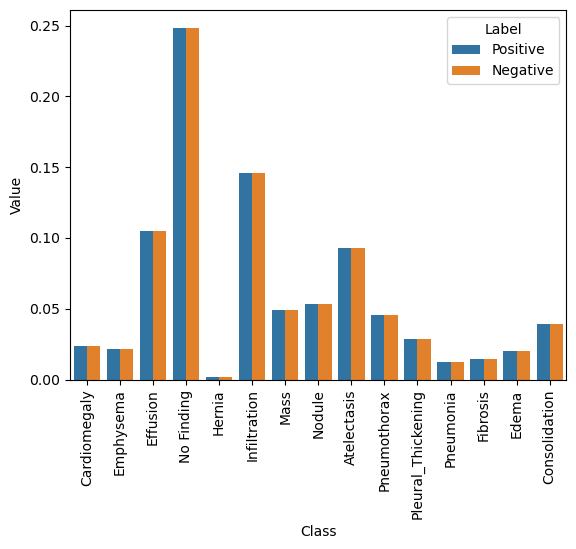

In [62]:
labels = list(uniqueLabels)
data = pd.concat([pos_contribution_data, neg_contribution_data])
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [65]:
def create_efficientB_model(cross_entropy_loss):
    
    inputs = Input(shape=(224, 224, 3))
    model = EfficientNetB0(input_tensor=inputs, weights='imagenet', include_top=False)
    model.trainable = False # Freeze the layer
    
    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    x = Dropout(0.2, name="top_dropout")(x)
    outputs = Dense(num_labels, activation="sigmoid", name="pred")(x)
    
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    # Note : Possibility to assign a learning rate.
    model.compile(optimizer=Adam(), 
                  loss = cross_entropy_loss.loss,
                  metrics=[
        'accuracy',
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes = num_labels, threshold=0.5),
        tf.keras.metrics.AUC(multi_label = True)
    ])
    
    return model

model = create_efficientB_model(cross_entropy_loss)

In [ ]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=8, batch_size=batch_size)

Epoch 1/8
 375/1963 [====>.........................] - ETA: 51:30 - loss: 1.1423 - accuracy: 0.2126 - recall_1: 0.6573 - f1_score: 0.1865 - auc: 0.7309

## Data Integration

### Load in Image Data
Reference: https://www.tensorflow.org/tutorials/load_data/images

In [7]:
image_count = len(list(data_dir.glob('*/*/*.png')))
print(image_count)

112120


In [8]:
# Set data loading parameters
batch_size = 32
img_height = 256
img_width = 256
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
for f in list_ds.take(5):
    print(f.numpy())

b'data\\images_011\\images\\00027017_002.png'
b'data\\images_006\\images\\00013652_001.png'
b'data\\images_002\\images\\00001893_000.png'
b'data\\images_010\\images\\00022192_007.png'
b'data\\images_006\\images\\00011673_000.png'


In [10]:
# TODO: modify to retrieve the labels from the dataEntry dataframe
def get_labels(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The last is the file's name?
    file_name = parts[-1].numpy()
    # file_name holds the string as bytes, need to convert to a string?
    file_name = str(file_name, encoding="utf-8")
    #print(file_name)
    # Get index
    imgIndexInDf = dataEntry[dataEntry["Image Index"] == file_name].index.tolist()[0]
    #print(imgIndexInDf)
    # Index into the one-hot encoding df to return the vector associated with the index
    oneHotVector = oneHotEncodings.loc[imgIndexInDf]
    oneHotTensor = tf.convert_to_tensor(oneHotVector, dtype=tf.float32)
    return oneHotTensor

In [11]:
for f in list_ds.take(5):
    print(get_labels(f))

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)


In [12]:
def decode_img(img):
    # channels=1 will give a grayscale image
    img = tf.io.decode_png(img, channels=1)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [13]:
for f in list_ds.take(5):
    print(decode_img(tf.io.read_file(f)))

tf.Tensor(
[[[ 2.5 ]
  [ 4.  ]
  [ 4.  ]
  ...
  [ 4.  ]
  [ 4.  ]
  [ 4.  ]]

 [[ 2.5 ]
  [ 4.  ]
  [ 4.  ]
  ...
  [ 4.  ]
  [ 4.  ]
  [ 4.  ]]

 [[ 2.5 ]
  [ 4.  ]
  [ 4.  ]
  ...
  [ 4.  ]
  [ 4.  ]
  [ 4.  ]]

 ...

 [[27.  ]
  [29.5 ]
  [16.  ]
  ...
  [ 5.  ]
  [ 5.  ]
  [ 6.  ]]

 [[32.75]
  [31.5 ]
  [23.25]
  ...
  [ 5.  ]
  [ 5.5 ]
  [ 6.  ]]

 [[19.5 ]
  [25.  ]
  [22.75]
  ...
  [ 5.  ]
  [ 5.5 ]
  [ 5.5 ]]], shape=(256, 256, 1), dtype=float32)
tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(256, 256, 1), dtype=float32)
tf.Tensor(
[[[210.75]
  [205.75]
  [200.  ]
  ...
  [209.75]
  [212.  ]
  [218.75]]

 [[194.25]
  [166.75]
  [143.5 ]
  ...
  [197.25]
  [198.25]
  [203.75]]

 [[137.5 ]
  [ 90.  ]
  [

In [14]:
def load_img(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [15]:
label_ds = list_ds.map(lambda x: tf.py_function(func=get_labels, inp=[x], Tout=tf.float32), num_parallel_calls=AUTOTUNE)

In [16]:
print(label_ds)
for label in label_ds.take(5):
    print("Label: ", label.numpy())

<ParallelMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>
Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Label:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
image_ds = list_ds.map(lambda x: tf.py_function(func=load_img, inp=[x], Tout=tf.float32), num_parallel_calls=AUTOTUNE)

In [18]:
print(image_ds)
for image in image_ds.take(5):
    print("Image shape: ", image.numpy().shape)

<ParallelMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>
Image shape:  (256, 256, 1)
Image shape:  (256, 256, 1)
Image shape:  (256, 256, 1)
Image shape:  (256, 256, 1)
Image shape:  (256, 256, 1)


In [19]:
complete_ds = tf.data.Dataset.zip(datasets=(image_ds, label_ds))

In [20]:
print(complete_ds)
for pair in complete_ds.take(5):
    print("Image, label vector pair:", pair)

<ZipDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>
Image, label vector pair: (<tf.Tensor: shape=(256, 256, 1), dtype=float32, numpy=
array([[[ 2.5 ],
        [ 4.  ],
        [ 4.  ],
        ...,
        [ 4.  ],
        [ 4.  ],
        [ 4.  ]],

       [[ 2.5 ],
        [ 4.  ],
        [ 4.  ],
        ...,
        [ 4.  ],
        [ 4.  ],
        [ 4.  ]],

       [[ 2.5 ],
        [ 4.  ],
        [ 4.  ],
        ...,
        [ 4.  ],
        [ 4.  ],
        [ 4.  ]],

       ...,

       [[27.  ],
        [29.5 ],
        [16.  ],
        ...,
        [ 5.  ],
        [ 5.  ],
        [ 6.  ]],

       [[32.75],
        [31.5 ],
        [23.25],
        ...,
        [ 5.  ],
        [ 5.5 ],
        [ 6.  ]],

       [[19.5 ],
        [25.  ],
        [22.75],
        ...,
        [ 5.  ],
        [ 5.5 ],
        [ 5.5 ]]], dtype=float32)>, <tf.Tensor: shape=(15,), dtype=float32, num

In [21]:
# Split into test and training datasets
val_size = int(image_count * 0.2)
train_ds = complete_ds.skip(val_size)
val_ds = complete_ds.take(val_size)

In [22]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

89697
22424


In [23]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [26]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    #plt.title(class_names[label])
    plt.axis("off")

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} InvalidArgumentError: {{function_node __wrapped__DecodePng_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input contents are too large for int: 15556176108 [Op:DecodePng]
Traceback (most recent call last):

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Dail_\AppData\Local\Temp\ipykernel_16168\1118244295.py", line 4, in load_img
    img = decode_img(img)

  File "C:\Users\Dail_\AppData\Local\Temp\ipykernel_16168\3532739111.py", line 3, in decode_img
    img = tf.io.decode_png(img, channels=1)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_image_ops.py", line 1290, in decode_png
    _ops.raise_from_not_ok_status(e, name)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 7209, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__DecodePng_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input contents are too large for int: 15556176108 [Op:DecodePng]


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [ ]:
# TODO: Standardize data? Rescaling can be done as layer in model...

In [28]:
# Save dataset for training model
train_ds.save(data_folder)

UnknownError: {{function_node __wrapped__SaveDataset_Tshard_func_args_0_device_/job:localhost/replica:0/task:0/device:CPU:0}} InvalidArgumentError: {{function_node __wrapped__DecodePng_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input contents are too large for int: 15556176108 [Op:DecodePng]
Traceback (most recent call last):

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Dail_\AppData\Local\Temp\ipykernel_16168\1118244295.py", line 4, in load_img
    img = decode_img(img)

  File "C:\Users\Dail_\AppData\Local\Temp\ipykernel_16168\3532739111.py", line 3, in decode_img
    img = tf.io.decode_png(img, channels=1)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_image_ops.py", line 1290, in decode_png
    _ops.raise_from_not_ok_status(e, name)

  File "C:\Users\Dail_\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 7209, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__DecodePng_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input contents are too large for int: 15556176108 [Op:DecodePng]


	 [[{{node EagerPyFunc}}]] [Op:SaveDataset]